<a href="https://colab.research.google.com/github/sherlock216/20251R0136COSE47101/blob/main/HDBSCAN_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!pip install hdbscan

In [35]:
!pip install umap-learn

In [36]:
import pandas as pd
import numpy as np
import hdbscan
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
import glob

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/COSE471/test/results2/github_profiles_total_v2.csv'

# 2. CSV 로드 + 컬럼 이름 공백 제거
df = pd.read_csv(file_path, index_col=False).fillna(0)
df.columns = df.columns.str.strip()  # ← 여기에서 컬럼 이름 공백 제거

print(f"총 {len(df)}개의 사용자 데이터 로드 완료")
print(f"컬럼 이름: {list(df.columns)}")

총 3799개의 사용자 데이터 로드 완료
컬럼 이름: ['user_ID', 'username', 'repo_count', 'Assembly', 'C', 'C++', 'C#', 'Dart', 'Go', 'Java', 'JavaScript', 'Kotlin', 'MATLAB', 'PHP', 'Python', 'Ruby', 'Rust', 'Scala', 'Swift', 'TypeScript']


In [44]:
# 2. repo_count 기준 필터링 (3번째 컬럼 기준으로 'repo_count'라고 명시)
filtered_df = df[df.iloc[:, 2] >= 10].copy()

# 3. 언어 비율 컬럼만 추출 (0: user_ID, 1: username, 2: repo_count → 3부터 끝까지)
language_columns = filtered_df.columns[3:]
X = filtered_df[language_columns].values

print(f"필터링된 사용자 수: {len(filtered_df)}")
print(f"사용된 feature 개수: {X.shape[1]}")

필터링된 사용자 수: 620
사용된 feature 개수: 17


In [45]:
# 데이터셋 검증용(Hopkins 점수 계산)
from sklearn.neighbors import NearestNeighbors
import random

def hopkins(X, sampling_size=0.05):
    """
    Calculate the Hopkins statistic for the dataset X.

    Parameters:
        X: array-like, shape (n_samples, n_features)
        sampling_size: float or int, number or fraction of samples to use

    Returns:
        Hopkins statistic (float)
    """
    if isinstance(sampling_size, float):
        n_samples = int(sampling_size * X.shape[0])
    else:
        n_samples = min(sampling_size, X.shape[0])

    d = X.shape[1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)

    rand_X = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (n_samples, d))
    rand_indices = random.sample(range(0, X.shape[0]), n_samples)
    ujd = []
    wjd = []

    for j in range(n_samples):
        u_dist, _ = nbrs.kneighbors([rand_X[j]], 2, return_distance=True)
        ujd.append(u_dist[0][0])

        w_dist, _ = nbrs.kneighbors([X[rand_indices[j]]], 2, return_distance=True)
        wjd.append(w_dist[0][1])  # [1] because [0] is the point itself

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    return H

hopkins_score = hopkins(X)
print(f"Hopkins Score: {hopkins_score:.3f}")

Hopkins Score: 0.936


In [38]:
# 3. 차원 축소 (UMAP)
print("UMAP으로 차원 축소 중")
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_reduced = umap_reducer.fit_transform(X)

UMAP으로 차원 축소 중


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [39]:
# 4. Dunn Index 계산 함수
def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels != -1]
    if len(unique_labels) < 2:
        return 0
    inter_cluster_distances = []
    for i in unique_labels:
        for j in unique_labels:
            if i < j:
                cluster_i = data[labels == i]
                cluster_j = data[labels == j]
                inter_cluster_distances.append(np.min(pdist(np.vstack([cluster_i, cluster_j]))))
    intra_cluster_distances = []
    for i in unique_labels:
        cluster_i = data[labels == i]
        if len(cluster_i) > 1:
            intra_cluster_distances.append(np.max(pdist(cluster_i)))
        else:
            intra_cluster_distances.append(0)
    if np.max(intra_cluster_distances) == 0:
        return 0
    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

In [40]:
best_result = {
    'min_cluster_size': None,
    'min_samples': None,
    'labels': None,
    'silhouette': -1,
    'dunn': 0,
    'n_clusters': 0
}

print("HDBSCAN 자동 튜닝 중 (목표는 5~10개 클러스터)")
for min_cluster_size in range(20, 101, 10):  # 20, 30, ..., 100
    for min_samples in [5, 10, 15]:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_method='eom'
        )
        labels = clusterer.fit_predict(X_reduced)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters < 5 or n_clusters > 10:
            continue

        sil = silhouette_score(X_reduced, labels) if n_clusters >= 2 else -1
        dunn = dunn_index(X_reduced, labels)

        print(f"  min_cluster_size={min_cluster_size}, min_samples={min_samples} → clusters={n_clusters}, silhouette={sil:.4f}, dunn={dunn:.4f}")

        if sil > best_result['silhouette']:
            best_result.update({
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'labels': labels,
                'silhouette': sil,
                'dunn': dunn,
                'n_clusters': n_clusters
            })

HDBSCAN 자동 튜닝 중 (목표는 5~10개 클러스터)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

  min_cluster_size=60, min_samples=15 → clusters=10, silhouette=0.0765, dunn=0.0002
  min_cluster_size=70, min_samples=5 → clusters=10, silhouette=0.1149, dunn=0.0001


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

  min_cluster_size=80, min_samples=5 → clusters=10, silhouette=0.1149, dunn=0.0001


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11


 최적 결과:
  min_cluster_size = 70
  min_samples = 5
  클러스터 수 = 10
  Silhouette Score = 0.1149
  Dunn Index = 0.0001


<ipython-input-10-daf2469b98a0>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color = plt.cm.get_cmap('tab20')(label / max(unique_labels)) if max(unique_labels) > 0 else 'gray'


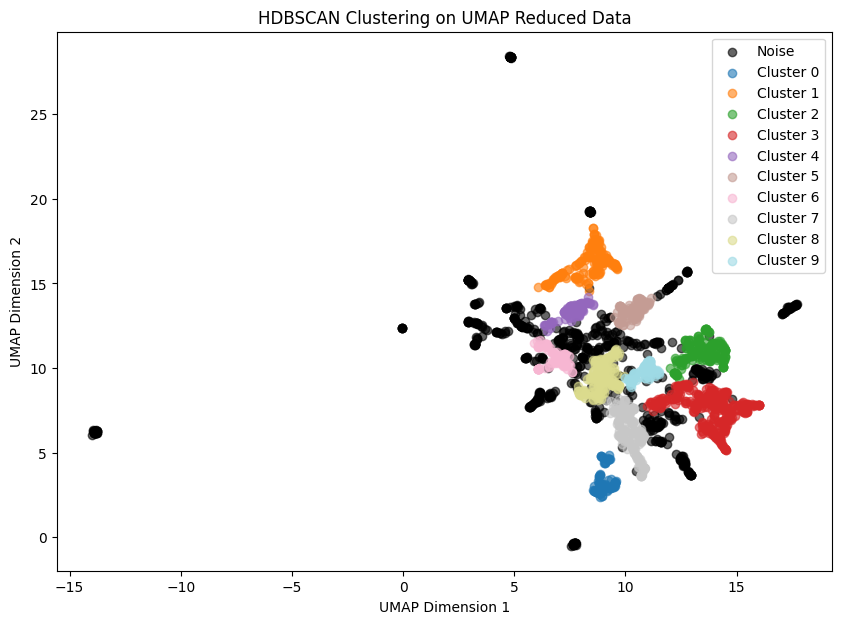

In [41]:
# 결과 출력
if best_result['labels'] is not None:
    print("\n 최적 결과:")
    print(f"  min_cluster_size = {best_result['min_cluster_size']}")
    print(f"  min_samples = {best_result['min_samples']}")
    print(f"  클러스터 수 = {best_result['n_clusters']}")
    print(f"  Silhouette Score = {best_result['silhouette']:.4f}")
    print(f"  Dunn Index = {best_result['dunn']:.4f}")

    # 저장
    filtered_df['Cluster_Label'] = best_result['labels']
    filtered_df.to_csv('/content/drive/MyDrive/Colab Notebooks/COSE471/test/result_hdbscan_tuned.csv', index=False)

    # 시각화
    visualize_clusters(X_reduced, best_result['labels'])
else:
    print("\n 클러스터 수가 5~10인 결과를 찾지 못했습니다.")


<ipython-input-42-29d865429e71>:17: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-42-29d865429e71>:17: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-42-29d865429e71>:17: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-42-29d865429e71>:17: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-42-29d865429e71>:17: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-42-29d865429e71>:17: UserWarning: Glyph 50616 (\N{HANGUL SYLLABLE EON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-42-29d865429e71>:17: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipy

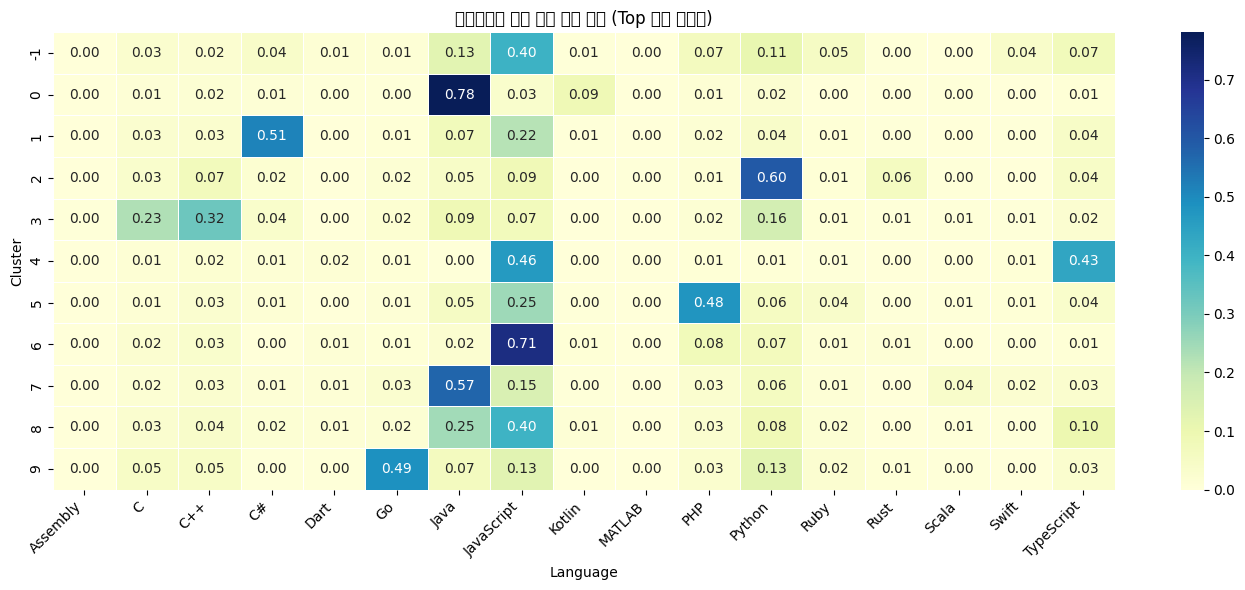

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 언어 컬럼만 선택
language_columns = filtered_df.columns[3:-1]  # Cluster_Label 제외

# 2. 클러스터별 평균 계산
cluster_avg = filtered_df.groupby('Cluster_Label')[language_columns].mean()

# 3. 시각화
plt.figure(figsize=(14, 6))
sns.heatmap(cluster_avg, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=0.5)
plt.title("클러스터별 언어 평균 사용 비율 (Top 언어 분석용)")
plt.xlabel("Language")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
